# Modelling vaccination strategies

Vaccination is an adaptive system with which we've all become familiar. The idea is simple to modify the trajectory of an epidemic outbreak by changing the susceptibilities of the population in which is spreads. In this notebook we'll explore how vaccination strategies can operate.

You can regard vaccination as an *intrinsic* adaptation, whereby the sidease process &ndash; SIR in our example &ndash; view the population differently, and this is the approach we'll take. One could also view is as *extrnisic* adaptation and change the susceptibilities in another process, and that would make sense if one wanted to model a vaccination *programme* alongside an outbreak. For the purposes of this notebook we'll assume that the disease breaks-out in a pre-vaccinated population.

In [1]:
# numpy
import numpy
from numpy.random import default_rng

# simulation
from epyc import Experiment, JSONLabNotebook, ParallelLab
from epydemic import SIR, PLCNetwork, StochasticDynamics, ProcessSequence, Monitor

# networks
import networkx
from collections import Counter

# data handling
import pandas
from pathlib import Path
datasets = Path("../../datasets")
datasets.mkdir(parents=True, exist_ok=True)

# plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

In [2]:
nb = JSONLabNotebook(Path(datasets, "10-05-vaccination.json"))

In [3]:
from multiprocessing import cpu_count
print("Current system has {c} cores in total".format(c=cpu_count()))

Current system has 8 cores in total


In [4]:
# pick the number of cores -- change this to change parallelism
nCores = 6

In [5]:
lab = ParallelLab(notebook=nb, cores=nCores)

## How vaccination works &ndash; in practice and theory

Vaccination works by exposing individuals' immune systems to fragments of a pathogen &ndash; *not* to the pathogen itself, but to some component of it that will trigger an iimmune reaction. This allows the immune system to learn the characteristics of of the pathogen so that, if it is encountered later, it is recognised as being an invader more quickly than would be the case if the pathogen was unknown. ItIn real disease outbreaks it's important to realise than a vaccine doesn't stop someone becoming infected &ndash; but it *does* cause their immune system to react more quickly and more forcefully, which can lead to the pathogen being eliminated before it can cause either symptoms or transmission to others. In many cases there's a more nuanced response that reduces, but doesn't entirely eliminate, symptoms and transmission.

To look at outbreaks in simulation, we need to decide how many of these nuances we want to include. As an initial model, the simplest approach is to assume that a vaccinated person is entirely and permanently immune from infection. Essentially they're "pre-removed" in the sense of SIR, where an R-individual takes no further part in the disease dynamics. Later we can relax this to build more sophisticated disease models that account for (for example) partial, variable, or waning immune reponses, possibly using additional compartments and more transitions and parameters.

## Random vaccination

Our adaptive vaccination process will simply treat vaccinated individuals as removed, changing the initial compartment of a random fraction of individuals to R.

In [6]:
class VaccinatedSIR(SIR):
    
    P_VACCINATED = 'pVaccinated'   #: Probability that an individual is initially removed.
    
    def __init__(self):
        super().__init__()
        
    def build(self, params):
        super().build(params)

        # change the initial compartment probabilities to vaccinate (remove) some fraction
        pInfected = params[SIR.P_INFECTED]
        pVaccinated = params[self.P_VACCINATED]
        self.changeCompartmentInitialOccupancy(SIR.INFECTED, pInfected)
        self.changeCompartmentInitialOccupancy(SIR.REMOVED, pVaccinated)
        self.changeCompartmentInitialOccupancy(SIR.SUSCEPTIBLE, 1.0 - pInfected - pVaccinated)

        # also monitor other compartments
        self.trackNodesInCompartment(SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(SIR.REMOVED)

We want to look at tghe progress of an outbreak and not just its end-state. To do this `epydemic` includes a process called `Monitor` that forms time series for all the compartments in a compartmented model at different sample points. When we built the model above we added tracking for the susceptible and removed compartments, which aren't tracked by default. `Monitor` can then be combined with the disease process to monitor its progress.

In [7]:
def makeVaccinated(N, alpha, cutoff,
                   pInfected, pInfect, pRemove, pVaccinated,
                   T):
    
    def sir_vac(lab):
        lab[SIR.P_INFECTED] = pInfected
        lab[SIR.P_INFECT] = pInfect
        lab[SIR.P_REMOVE] = pRemove
        lab[VaccinatedSIR.P_VACCINATED] = pVaccinated
        lab[PLCNetwork.N] = N
        lab[PLCNetwork.EXPONENT] = alpha
        lab[PLCNetwork.CUTOFF] = cutoff
        
        # sample the compartments every 50 timesteps
        lab[Monitor.DELTA] = T / 50

        v = VaccinatedSIR()
        v.setMaximumTime(T)
        m = ProcessSequence([v, Monitor()])
        e = StochasticDynamics(m, PLCNetwork())
        lab.runExperiment(e)
        
    return sir_vac

We can then see what happens to the outbreaks. We'll use a powerlaw-with-cutoff topology, since we believe that is a decent model of a human contact structure, but change the cutoff to allow more highly-connected nodes to emerge.

In [8]:
# Network parameters
N = int(1e4)
alpha = 2
cutoffs = [10, 30, 40, 80]

# Simulation time
T = 1000

# Disease parameters
pInfected = 0.001
pInfect = 0.01
pRemove = 0.002

# Vaccination parameter
pVaccinated = 0.6       # 60% vaccination at random

In [9]:
lab.createWith("sirv_plc_random",
               makeVaccinated(N, alpha, cutoffs,
                              pInfected, pInfect, pRemove, pVaccinated,
                              T),
               "SIR with random vaccination on PLC networks")

True

To plot the monitored time series we use the `Monitor.timeSeriesForCompartment` static method that converts a compartment name into the corresponding time series in the results.

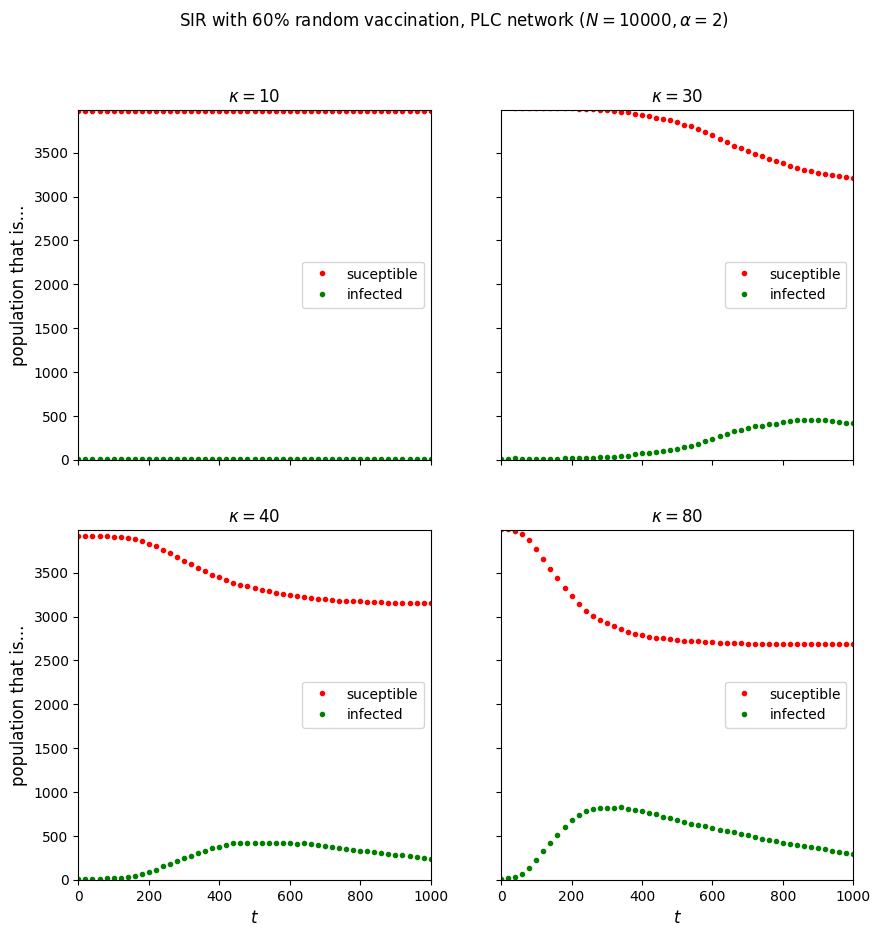

In [10]:
nb.select("sirv_plc_random")
df = lab.dataframe()
    
(fig, axs) = plt.subplots(2, 2, sharex=True, sharey=True,
                          figsize=(10, 10))

for (ax, cutoff) in [ (axs[0][0], cutoffs[0]),
                      (axs[0][1], cutoffs[1]),
                      (axs[1][0], cutoffs[2]), 
                      (axs[1][1], cutoffs[3]) ]:
    rc = df[df[PLCNetwork.CUTOFF] == cutoff]
    timeseries = rc.iloc[0]
    ts = timeseries[Monitor.OBSERVATIONS]
    sss = timeseries[Monitor.timeSeriesForLocus(SIR.SUSCEPTIBLE)]
    iss = timeseries[Monitor.timeSeriesForLocus(SIR.INFECTED)]
    rss = timeseries[Monitor.timeSeriesForLocus(SIR.REMOVED)]

    ax.plot(ts, sss, 'r.', label='suceptible')
    ax.plot(ts, iss, 'g.', label='infected')
    #ax.plot(ts, rss, 'ks', label='removed')

    ax.set_title('$\\kappa = {kappa:.0f}$'.format(kappa=cutoff))
    ax.set_xlim([0, T])
    ax.set_ylim([0, N * (1.0 - pVaccinated - pInfected)])
    ax.legend(loc='center right')

# fine-tune the diagram
plt.suptitle(f'SIR with {pVaccinated:.0%} random vaccination, PLC network ($N = {N}, \\alpha={alpha}$)')
for y in range(2):
    axs[y][0].set_ylabel('population that is...')
for x in range(2):
    axs[1][x].set_xlabel('$t$')

plt.show()

What can we tell from these graphs? Firstly, in a population of 10,000 individuals we only ever have about 4,000 susceptibles, because of the 60% removal through vaccination. At low cutoffs vaccination is extremely effective. As the cutoff increases we see that the outbreak becomes both more severe (more people are infected because of the increased contacts) and faster (the outbreak peaks earlier). With 60% vaccination on the most-connected network we still get about 10% of the population infected. This is *herd immunity* at work, but getting it required reaching quite a large fraction of the population ahead of time for vaccination. Could we do better?

## Exploring degree

Let's dig-in to the degree distribtion of our population a little by creating a network and extracting its degree statistics.

In [11]:
params = dict()
params[PLCNetwork.N] = N
params[PLCNetwork.EXPONENT] = alpha
params[PLCNetwork.CUTOFF] = cutoffs[-1]    # the highest cutoff
g = PLCNetwork().set(params).generate()

In [12]:
ks = sorted(list(dict(networkx.degree(g)).values()))
print(f'Maximum degree = {max(ks)}')
print(f'Mean node degree = {numpy.mean(ks):.2f}')

Maximum degree = 91
Mean node degree = 2.65


That's quite a difference! The highest-degree nodes have degrees close to the cutoff.

In [13]:
h = 10
print('Highest {h} nodes by degree {l}'.format(h=h, l=ks[-h:]))

Highest 10 nodes by degree [65, 66, 67, 74, 77, 78, 78, 85, 85, 91]


We might assume that these nodes &ndash; the high-degree hubs &ndash; will be most effective in spreading the disease. Let's test this in reverse, by *avoiding* vaccinating the high-degree nodes. If that sounds perverse, it essentially models a *failed* vaccination strategy and its effects.

In [14]:
class VaccinatedLowDegreeSIR(VaccinatedSIR):

    K_HIGH_FRACTION = 'k_high_fraction'
    
    def __init__(self):
        super().__init__()
        
    def setUp(self, params):
        super().setUp(params)
        
        # look through the fraction of high-degree nodes and
        # make them susceptible again, replacing them with
        # another node chosen at random
        rng = numpy.random.default_rng()
        g = self.network()
        ns = list(g.nodes())
        h = int(len(ns) * params[self.K_HIGH_FRACTION])
        degrees = dict(networkx.degree(g))
        ks = sorted(list(degrees.values()))
        ks_high = set(ks[-h:])
        ns_high = [n for n in ns if degrees[n] in ks_high]
        for n in ns_high:
            if self.getCompartment(n) == self.REMOVED:
                # node is removed, make it susceptible again
                self.setCompartment(n, self.SUSCEPTIBLE)
                
                # choose another node and remove it in
                # place of the node we just forced to
                # be susceptible
                while True:
                    i = rng.integers(0, len(ns) - 1)
                    m = ns[i]
                    if self.getCompartment(m) == self.SUSCEPTIBLE:
                        # found a susceptible node, remove it
                        self.changeCompartment(m, self.REMOVED)
                        break

In [15]:
def makeVaccinatedLowDegree(N, alpha, cutoff,
                            pInfected, pInfect, pRemove, pVaccinated,
                            kHighFraction,
                            T):
    
    def sir_lovac(lab):
        lab[SIR.P_INFECTED] = pInfected
        lab[SIR.P_INFECT] = pInfect
        lab[SIR.P_REMOVE] = pRemove
        lab[VaccinatedSIR.P_VACCINATED] = pVaccinated
        lab[VaccinatedLowDegreeSIR.K_HIGH_FRACTION] = kHighFraction
        lab[PLCNetwork.N] = N
        lab[PLCNetwork.EXPONENT] = alpha
        lab[PLCNetwork.CUTOFF] = cutoff
        lab[Monitor.DELTA] = T / 50

        v = VaccinatedLowDegreeSIR()
        v.setMaximumTime(T)
        m = ProcessSequence([v, Monitor()])
        e = StochasticDynamics(m, PLCNetwork())
        lab.runExperiment(e)
        
    return sir_lovac

Let's focus on the highest-connected network.

In [16]:
cutoff = cutoffs[-1]
kHighFraction = 0.08      # avoid the top 8% of the degree distribution

In [17]:
lab.createWith("sirv_plc_lowdegree",
               makeVaccinatedLowDegree(N, alpha, cutoff,
                                       pInfected, pInfect, pRemove, pVaccinated,
                                       kHighFraction,
                                       T),
               "SIR avoiding the highest-degree nodes on PLC networks")

True

This simulation has run essentially the disease process as the first one above, but has avoided vaccinating the most-connected fraction. We can put the two results side by side to compare them.

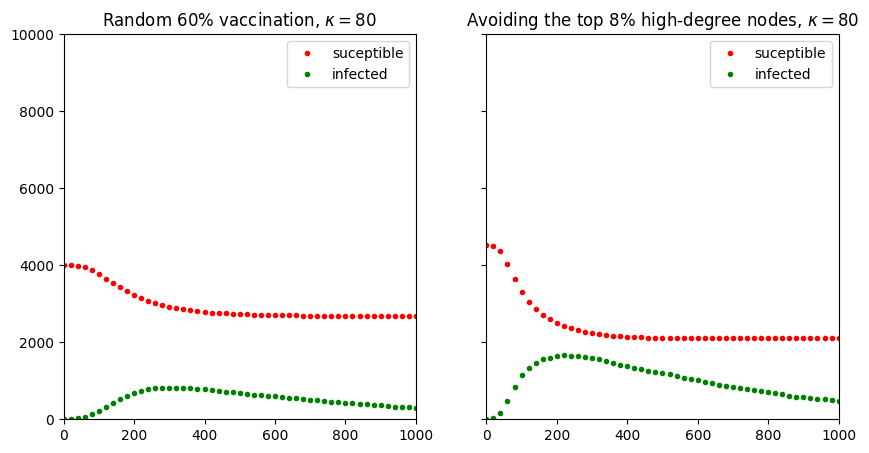

In [18]:
(fig, axs) = plt.subplots(1, 2, sharey=True,
                          figsize=(10, 5))

# plot the original behaviour
nb.select("sirv_plc_random")
df = lab.dataframe()

ax = axs[0]
rc = df[df[PLCNetwork.CUTOFF] == cutoff]
timeseries = rc.iloc[0]
ts = timeseries[Monitor.OBSERVATIONS]
sss = timeseries[Monitor.timeSeriesForLocus(SIR.SUSCEPTIBLE)]
iss = timeseries[Monitor.timeSeriesForLocus(SIR.INFECTED)]
rss = timeseries[Monitor.timeSeriesForLocus(SIR.REMOVED)]

ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')

ax.set_title(f'Random {pVaccinated:.0%} vaccination, $\\kappa = {cutoff:.0f}$')
ax.set_xlim([0, T])
ax.set_ylim([0, N])
ax.legend(loc='upper right')

# plot the targetted behaviour
nb.select("sirv_plc_lowdegree")
df = lab.dataframe()
ax = axs[1]

rc = df[df[PLCNetwork.CUTOFF] == cutoff]
timeseries = rc.iloc[0]
ts = timeseries[Monitor.OBSERVATIONS]
sss = timeseries[Monitor.timeSeriesForLocus(SIR.SUSCEPTIBLE)]
iss = timeseries[Monitor.timeSeriesForLocus(SIR.INFECTED)]
rss = timeseries[Monitor.timeSeriesForLocus(SIR.REMOVED)]

ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')

ax.set_title(f'Avoiding the top {kHighFraction:.0%} high-degree nodes, $\\kappa = {cutoff:.0f}$')
ax.set_xlim([0, T])
ax.legend(loc='upper right')

plt.show()

So avoiding the top-degree nodes both significantly increased the outbreak size and made it happen sooner and faster. This strongly supports the hypothesis that it's important to vaccinate the individuals with the most social contact &ndash; and lets us quantify this.

## Targetted vaccination

So now let's make use of what we've learned to develop a vaccination strategy that might work better: target the high-degree nodes. We could use this as well as random vaccination, and in reality that's often what happens. But to bring out the effect of degree as strongly as possible, we'll instead vaccinate the highest-degree nodes *and only those nodes*, leaving the rest of the population susceptible. This is a radical strategy in practice, but helps us explore the space of possible approaches.

In defining the disease model we'll again build on the SIR process and again capture the time series of all the compartments for plotting later. By default SIR has no removed nodes, and once that set-up is complete we'll change the compartments of the highest-degree nodes by hand.

In [19]:
class VaccinatedHighDegreeSIR(SIR):

    K_VACCINATED_FRACTION = 'k_vaccinated_fraction'
    
    def __init__(self):
        super().__init__()
        
    def build(self, params):
        super().build(params)
        
        # also monitor other compartments
        self.trackNodesInCompartment(SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(SIR.REMOVED)       
        
    def setUp(self, params):
        super().setUp(params)

        # look for the fraction of highest-degree nodes
        # and vaccinate (remove) them
        g = self.network()
        ns = list(g.nodes())
        h = int(len(ns) * params[self.K_VACCINATED_FRACTION])
        degrees = dict(networkx.degree(g))
        ks = sorted(list(degrees.values()))
        ks_high = set(ks[-h:])
        ns_high = [n for n in ns if degrees[n] in ks_high]
        for n in ns_high:
            # remove (vaccinate) the node
            self.changeCompartment(n, self.REMOVED)

In [20]:
def makeVaccinatedHighDegree(N, alpha, cutoff,
                             pInfected, pInfect, pRemove,
                             kVaccinatedFraction,
                             T):
    
    def sir_hivac(lab):
        lab[SIR.P_INFECTED] = pInfected
        lab[SIR.P_INFECT] = pInfect
        lab[SIR.P_REMOVE] = pRemove
        lab[VaccinatedHighDegreeSIR.K_VACCINATED_FRACTION] = kVaccinatedFraction
        lab[PLCNetwork.N] = N
        lab[PLCNetwork.EXPONENT] = alpha
        lab[PLCNetwork.CUTOFF] = cutoff
        lab[Monitor.DELTA] = T / 50

        v = VaccinatedHighDegreeSIR()
        v.setMaximumTime(T)
        m = ProcessSequence([v, Monitor()])
        e = StochasticDynamics(m, PLCNetwork())
        lab.runExperiment(e)
        
    return sir_hivac

Since we've said that this is a radical strategy, let's be *really* aggressive and target only a tiny fraction of the nodes for vaccination.

In [21]:
kVaccinatedFraction = 0.03   # top 3% of high-degree nodes

In [22]:
lab.createWith("sirv_plc_highdegree",
               makeVaccinatedHighDegree(N, alpha, cutoff,
                                        pInfected, pInfect, pRemove,
                                        kVaccinatedFraction,
                                        T),
               "SIR with targetted vaccination of high-degre nodes on PLC networks")

True

Again we can compare our results against the baseline random strategy.

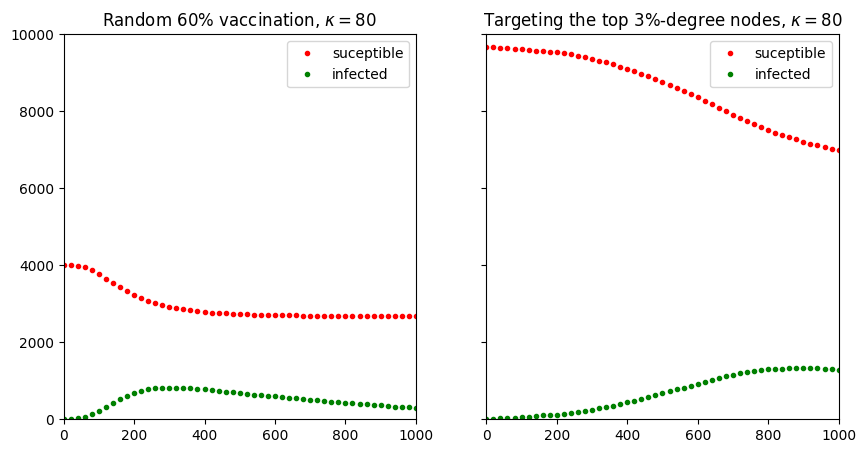

In [23]:
(fig, axs) = plt.subplots(1, 2, sharey=True,
                          figsize=(10, 5))

# plot the original behaviour
nb.select("sirv_plc_random")
df = lab.dataframe()

ax = axs[0]
rc = df[df[PLCNetwork.CUTOFF] == cutoff]
timeseries = rc.iloc[0]
ts = timeseries[Monitor.OBSERVATIONS]
sss = timeseries[Monitor.timeSeriesForLocus(SIR.SUSCEPTIBLE)]
iss = timeseries[Monitor.timeSeriesForLocus(SIR.INFECTED)]
rss = timeseries[Monitor.timeSeriesForLocus(SIR.REMOVED)]

ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')

ax.set_title(f'Random {pVaccinated:.0%} vaccination, $\\kappa = {cutoff:.0f}$')
ax.set_xlim([0, T])
ax.legend(loc='upper right')

# plot the targetted behaviour
nb.select("sirv_plc_highdegree")
df = lab.dataframe()
ax = axs[1]

rc = df[df[PLCNetwork.CUTOFF] == cutoff]
timeseries = rc.iloc[0]
ts = timeseries[Monitor.OBSERVATIONS]
sss = timeseries[Monitor.timeSeriesForLocus(SIR.SUSCEPTIBLE)]
iss = timeseries[Monitor.timeSeriesForLocus(SIR.INFECTED)]
rss = timeseries[Monitor.timeSeriesForLocus(SIR.REMOVED)]

ax.plot(ts, sss, 'r.', label='suceptible')
ax.plot(ts, iss, 'g.', label='infected')
#ax.plot(ts, rss, 'ks', label='removed')

ax.set_title(f'Targeting the top {kVaccinatedFraction:.0%}-degree nodes, $\\kappa = {cutoff:.0f}$')
ax.set_xlim([0, T])
ax.set_ylim([0, N])
ax.legend(loc='upper right')

plt.show()

What can we extract from this? There is still an outbreak, and it's actually bigger than the random-vaccinated case. But is occurs substantially more slowly, and gets an impressive reduction given that it only targets a tiny number of individuals. What would happen if we vaccinated slightly more individuals? &ndash; how does the effectiveness of targeting vary?

What this shows us is that targeted adaptive strategies can be extremely effective in changing the course of outbreaks. The random strategy requires mobilising a lot of resources, and similar results can be achieved far more cheaply (in resource terms, anyway) by targeting these resources &ndash; if we know whom and how to target.

This is the perhaps simplest model of vaccination, of course. There are several ways in which it can be extended, to include partial immunity, or different targeting choices, or elongated vaccination programmes running alongside the outbreak (making the adaptation extrinsic to the disease). This would allow exploration of a wider range of strategies for disease countermeasures.